## Week 4: Logistic Regression - part I

Instructor: Cornelia Ilin <br>
Email: cilin@ischool.berkeley.edu <br>

#### ``Objectives``

1. Supervised ML: predict binary target variables with logistic regression

2. Gradient Descent for logistic regression

3. Use AI/ML to predict types of wine cultivars

#### ``Data``

[Source and data description](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data): these data results from a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines. The attributes are alcohol, malic acid, ash, alcalinity of ash, magnesium, total phenols, flavonoids, nonflavonoid phenols, proanthocyanins, color intensity, hue, OD280/OD315 of diluted wines, and proline.

We will restrict our attention to two class labels (cultivar 0 and 1) and two features ('alcohol' and 'OD280/OD315_of_diluted_wines') for today's class.

### Step 1: Import packages

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import os
import random

# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

random.seed(2)

### Step 2: Define functions

In [2]:
def read_wine_data():
    """Read the wine dataset from 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
    # param: None
    # return df and X,y np.arrays for training and test (cleaning included)
    """
    # read data
    df = pd.read_csv('https://archive.ics.uci.edu/'
                          'ml/machine-learning-databases/wine/wine.data',
                          header=None)

    # define columns
    df.columns = ['class_label', 'alcohol', 'malic_acid', 'ash',
                  'alcalinity_of_ash', 'magnesium', 'total_pphenols',
                  'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins',
                  'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines',
                  'proline']

    print('Shape of df wine:', df.shape)
    
    return df

In [3]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

In [4]:
def draw_neural_net(ax, layer_sizes, coefs_, intercepts_,
                    left=0.1, right=.5, bottom=0.1, top=.5):
    '''
    Draw a neural network cartoon using matplotilb.
    Adapted: https://gist.github.com/craffel/2d727968c3aaebd10359
    
    Args:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    
    # Input-Arrows
    layer_top_0 = v_spacing*(layer_sizes[0] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[0]):
        plt.arrow(left-0.18, layer_top_0 - m*v_spacing, 0.12, 0,  lw=1, head_width=0.01, head_length=0.02)
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/8.,
                                color='w', ec='k', zorder=4)
            if n == 0:
                plt.text(left-0.125, layer_top - m*v_spacing, r'$X_{'+str(m+1)+'}$', fontsize=15)
            elif (n_layers == 3) & (n == 1):
                plt.text(n*h_spacing + left+0.00, layer_top - m*v_spacing+ (v_spacing/8.+0.01*v_spacing), r'$H_{'+str(m+1)+'}$', fontsize=15)
            elif n == n_layers -1:
                plt.text(n*h_spacing + left+0.10, layer_top - m*v_spacing, r'$y_{'+str(m+1)+'}$', fontsize=15)
            ax.add_artist(circle)
    # Bias-Nodes
    for n, layer_size in enumerate(layer_sizes):
        if n < n_layers -1:
            x_bias = (n+0.5)*h_spacing + left
            y_bias = top + 0.005
            circle = plt.Circle((x_bias, y_bias), v_spacing/8., color='w', ec='k', zorder=4)
            plt.text(x_bias-(v_spacing/8.+0.10*v_spacing-0.01), y_bias, r'$1$', fontsize=15)
            ax.add_artist(circle)   
    # Edges
    # Edges between nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
                xm = (n*h_spacing + left)
                xo = ((n + 1)*h_spacing + left)
                ym = (layer_top_a - m*v_spacing)
                yo = (layer_top_b - o*v_spacing)
                rot_mo_rad = np.arctan((yo-ym)/(xo-xm))
                rot_mo_deg = rot_mo_rad*180./np.pi
                xm1 = xm + (v_spacing/8.+0.05)*np.cos(rot_mo_rad)
                if n == 0:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.1)*np.sin(rot_mo_rad) + .01
                else:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                plt.text(xm1, ym1,
                         str(round(coefs_[n][m, o],2)),
                         rotation = rot_mo_deg,
                         fontsize = 10)
    # Edges between bias and nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        if n < n_layers-1:
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        x_bias = (n+0.5)*h_spacing + left
        y_bias = top + 0.005 
        for o in range(layer_size_b):
            line = plt.Line2D([x_bias, (n + 1)*h_spacing + left],
                          [y_bias, layer_top_b - o*v_spacing], c='k')
            ax.add_artist(line)
            xo = ((n + 1)*h_spacing + left)
            yo = (layer_top_b - o*v_spacing)
            rot_bo_rad = np.arctan((yo-y_bias)/(xo-x_bias))
            rot_bo_deg = rot_bo_rad*180./np.pi
            xo2 = xo - (v_spacing/8.+0.01)*np.cos(rot_bo_rad)
            yo2 = yo - (v_spacing/8.+0.01)*np.sin(rot_bo_rad)
            xo1 = xo2 -0.08 * np.cos(rot_bo_rad)
            yo1 = yo2 -0.05 * np.sin(rot_bo_rad)
            plt.text(xo1, yo1,
                 str(round(intercepts_[n][o],2)),
                 rotation = rot_bo_deg,
                 fontsize = 10)    
                
    # Output-Arrows
    layer_top_0 = v_spacing*(layer_sizes[-1] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[-1]):
        plt.arrow(right+0.015, layer_top_0 - m*v_spacing, 0.16*h_spacing, 0,  lw =1, head_width=0.01, head_length=0.02)

---
### Step 3: Read data
---

In [5]:
df = read_wine_data()
df.head()

Shape of df wine: (178, 14)


,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_pphenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,OD280/OD315_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


The original data contains 178 observations and 13 features.

---
### Step 4: Data preprocessing

---

``labels and features``

In [6]:
# recode class labels (from 0 to 2 instead of 1 to 3)
class_mapping = {label: idx for idx, label in enumerate(np.unique(df.class_label))}
class_mapping
df['class_label'] = df.class_label.map(class_mapping)

# select only labels 0 and 1 (we want to turn the prediction problem into binary classification)
df = df[df.class_label !=2]
labels = ['class_label']

# select only 2 features (easier to visualize features and decission bounderies in a 2D space)
features = ['alcohol', 'OD280/OD315_of_diluted_wines']

# ansamble data
df = df[labels+features]

# print data and shapes
print('Class labels:', df['class_label'].unique())
print('Features:', df.columns[1:])
print('Shape of data', df.shape)
df.head()

Class labels: [0 1]
Features: Index(['alcohol', 'OD280/OD315_of_diluted_wines'], dtype='object')
Shape of data (130, 3)


,class_label,alcohol,OD280/OD315_of_diluted_wines
0,0,14.23,3.92
1,0,13.20,3.40
2,0,13.16,3.17
3,0,14.37,3.45
4,0,13.24,2.93


``split data into training and test``

In [7]:
# define outcome #
##################
y = df['class_label'].values

# define features #
###################
X = df[['alcohol', 'OD280/OD315_of_diluted_wines']].values

# split #
#########
# set seed for consistent behavior
np.random.seed(1234)

split = (0.7,0.3) #70% training and 30% test
shuffle = np.random.permutation(np.arange(y.shape[0])) # very important to shuffle the data. Why?
X, y = X[shuffle], y[shuffle]

splits = np.multiply(len(y), split).astype(int) 
X_train, X_test = np.split(X, [splits[0]])
y_train, y_test = np.split(y, [splits[0]])

print('Size of X_train', X_train.shape)
print('Size of y_train', y_train.shape)
print('Size of X_test', X_test.shape)
print('Size of y_test', y_test.shape)


# df for y_train and X_train #
##############################
# easier for EDA later on
df_train = pd.concat(
    [pd.DataFrame(y_train), pd.DataFrame(X_train)],
    axis=1
)

# rename columns
df_train.columns=['class_label', 'alcohol', 'OD280/OD315_of_diluted_wines']

Size of X_train (91, 2)
Size of y_train (91,)
Size of X_test (39, 2)
Size of y_test (39,)


``feature scalling for optimal performance``

standardization: center the feature columns at mean 0 and std 1. Prefered over normalization, as it preservers useful information about outliers and makes the algorithm less sensitive to them. This is what we will be implementing today.

In [8]:
# standardize
sc_x = StandardScaler()

X_train_std = sc_x.fit(X_train).transform(X_train)
X_test_std = sc_x.fit(X_train).transform(X_test)

Note how we fit the StandardScaler() only on the training data, and use the mean and sd parameters to transform the test data!

---
### Step 5: Exploratory Data Analysis (EDA)
---

Prior to training a model it is important to perform exploratory data analysis. The idea is to detect any missing data, the presence of outliers, the feature distribution, and the relationship between features and outcome. Note that typically there is a back and forth between Step 4 and 5, depending on how satisfied you are with the results of the EDA.

In [9]:
df_train.isna().sum()

class_label                     0
alcohol                         0
OD280/OD315_of_diluted_wines    0
dtype: int64

``correlation matrix of outcome and feature variables``

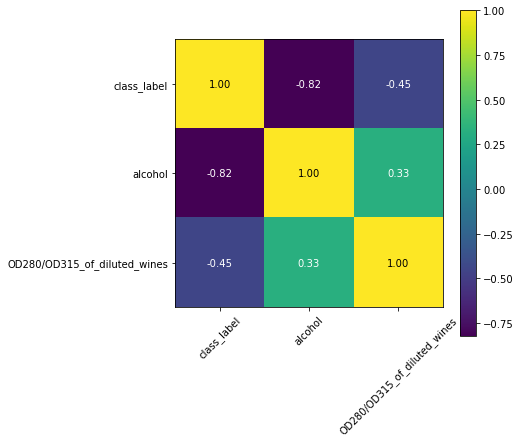

In [10]:
cm = df_train.corr().values
hm = heatmap(
    cm,
    row_names=df_train.columns,
    column_names=df_train.columns,
    figsize=(6, 6)
)

<span style="color:chocolate"> *Question:*</span> Which features seem to be most informative to predict the cultivar class?

``histogram of clases and features``

Here we will examine the distribution of the outcome variable (cultivar class) and the distribution of the two features (alcohol content and ODs of diluted wines).

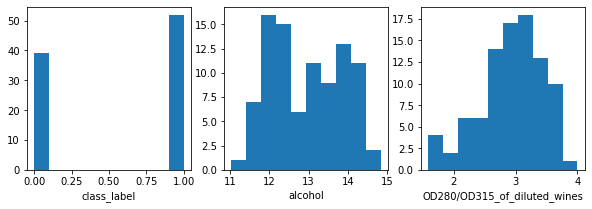

In [11]:
columns = ['class_label', 'alcohol', 'OD280/OD315_of_diluted_wines']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for idx, ax in enumerate(axes.flatten()):
    # plot histogram
    ax.hist(df_train[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])

<span style="color:chocolate"> *Question:*</span> As you can see from the histogram, there seems to be some class imbalance in the data. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume an equal occurrence of classes and are designed to maximize the overall classification accuracy. <span style="color:chocolate"> Suggest a way to deal with imbalanced data.</span>

``distribution of features by classes``

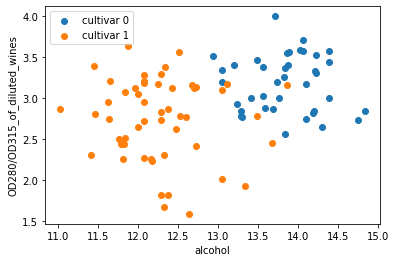

In [12]:
# cultivar class 0
plt.scatter(
    df_train.loc[df_train.class_label==0, 'alcohol'],
    df_train.loc[df_train.class_label==0, 'OD280/OD315_of_diluted_wines'],
    label='cultivar 0'
)

# cultivar class 1
plt.scatter(
    df_train.loc[df_train.class_label==1, 'alcohol'],
    df_train.loc[df_train.class_label==1, 'OD280/OD315_of_diluted_wines'],
    label='cultivar 1'
)

plt.xlabel('alcohol');
plt.ylabel('OD280/OD315_of_diluted_wines');
plt.legend(loc='upper left');

Logistic regression is very simple to implement and performs well on linearly separable classes. We can see our data is "almost" linearly separable so we should expect a high prediction accuracy.

---
### Step 6: Analysis - Logistic Regression with two features
---

``from scratch``

We will start by fitting the training data using <span style="color:chocolate"> batch gradient descent</span> and we will implement this algorithm from scratch. We will then use TensorFlow to see how the predictions compare. <br>

Below you can see a visual representation of the difference between the logistic regression and the linear regression model.

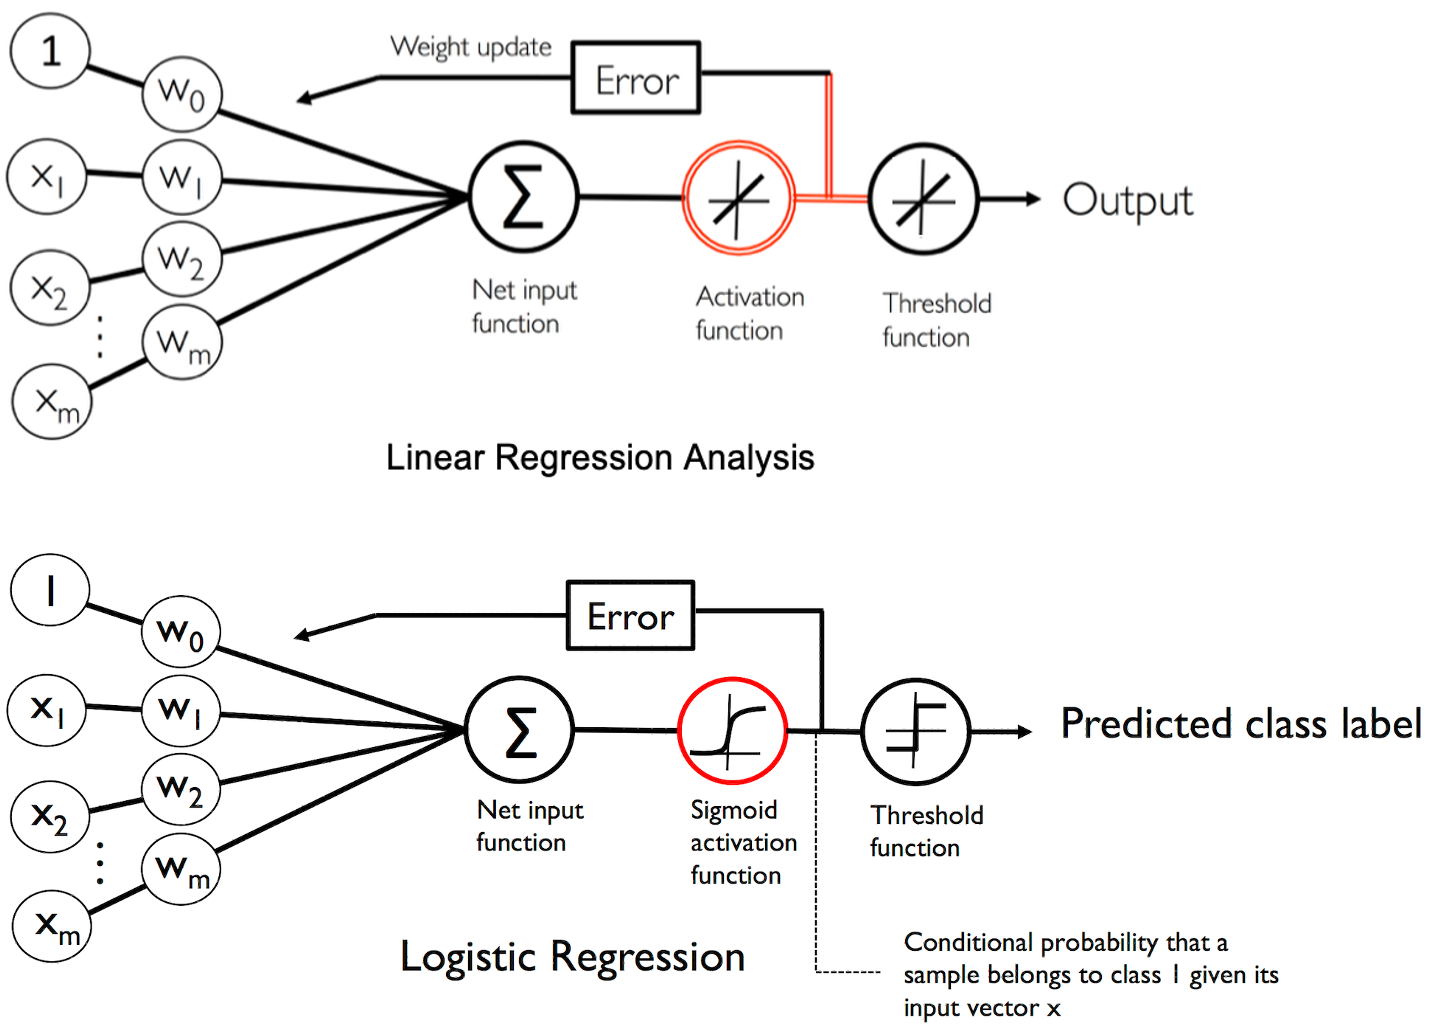

In [13]:
Image(filename='./images/linear_logistic.png', width=500)

As you can see, comparing to the Linear Regression model, we need to <span style="color:chocolate"> redefine the shape of the activation function and the threshold function</span> to fit a logistic regression model.

Let j represent features, j = [1,...,m]

Let i represent observations, i = [1, ..., n]


``Net input function``:

z= $w_{0} \cdot 1 + w_{2} \cdot x_{1} + w_{2} \cdot x_{2} + ... + w_{m} \cdot x_{m}$

``Sigmoid activation function``:

$\phi(z)= \frac{1}{1+exp(-z)}$


`` Compute error``:

$(y\_actual_{i} - \phi(z_{i}))$, , where $\phi(z_{i})$ is $y\_pred_{i}$

``Update weights``:

$w_{j} := w_{j} + \Delta w_{j}, \forall j \in {1,...,m}$

$\Delta w_{j} = \eta \sum _{i}(y\_actual_{i} - \phi(z_{i}))\cdot x_{i,j}, \forall j \in {1,...,m}, \forall i \in {1,...,n}$


``Threshold function``: (changed to reflect a logistic outcome)

$\tau(z)  = 
\begin{cases}
1,  if z \geq 0.5,\\
0, otherwise
\end{cases}
$



`` Note on Batch Gradient Descent``:

The weights are updated using **all training examples** (see the summation operator in the equation $\Delta w_{j}$)

Now let's code the math:

In [14]:
# define shape of temp_X_train_std
shape_X_train_std = X_train_std.shape[1]

# Step 1: initalize hyperparameters
eta = 0.01
n_iter = 40
random_state = 1

# Step 2: initalize weights (to small random numbers)
rgen = np.random.RandomState(random_state)
w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + shape_X_train_std)

# Step 3: initialize cost lists
cost_ = []

# Step 4: compute net input, linear activation function, update weights, keep track cost
def fit(X, y):
    for iter_ in range(n_iter):
        # compute the net input function
        net_input = np.dot(X, w_[1:]) + w_[0]

        # compute the sigmoid activation function; this gives us y_pred
        temp_y_pred = 1. / (1. + np.exp(-np.clip(net_input, -250, 250)))
        
        # compute error
        errors = (y - temp_y_pred)

        # update weights (notice how weights are updated using all training examples!)
        w_[1:] += eta * X.T.dot(errors)
        w_[0] += eta * errors.sum()

        # compute cost (we find weights by minimizing costs; in the linear model the cost is the SSE/2, but in the logistic regression the cost function is the log-likelihood)
        cost = -y.dot(np.log(temp_y_pred)) - ((1 - y).dot(np.log(1 - temp_y_pred)))
        cost_.append(cost)
        
    return cost_

# Step 5: predict y: compute the threshold (unit step) function; transforms a continous-valued y into a binary y
def predict(X):
    net_input = np.dot(X, w_[1:]) + w_[0]
    y_pred = net_input
    
    # threshold function
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    
    return y_pred

Model fit

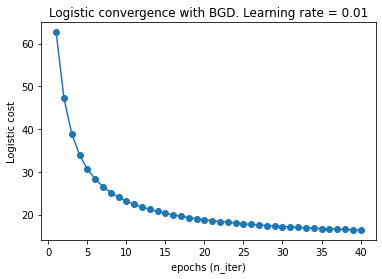

In [15]:
cost_ = fit(X_train_std, y_train)

# plot cost
plt.plot((range(1, len(cost_) + 1)), cost_, marker='o');
plt.xlabel('epochs (n_iter)');
plt.ylabel('Logistic cost'); # number of times y_actual != y_pred

plt.title('Logistic convergence with BGD. Learning rate = ' + str(eta));

<span style="color:chocolate"> *Exercise:*</span> 

What do you think about the convergence of the model? Try increasing the number of iterations and see what happens. Then see what happens if you change the learning rate.

---

Prediction (on trainining and test data)

In [16]:
y_train_pred = predict(X_train_std)
y_test_pred = predict(X_test_std)

# print
print('Train predictions:', y_train_pred)
print('Test predictions:', y_test_pred)

Train predictions: [1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1
 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1
 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 1]
Test predictions: [1 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0
 1 0]


In [17]:
y_test

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0])

Evaluation (on training and test data)

In [18]:
# print accuracy for train
print('Training, misclassified examples: %d' % (y_train != y_train_pred).sum())
error_train = (y_train != y_train_pred).sum()/len(y_train_pred)
print('Training, prediction accuracy: %.3f'% (1-error_train))

# print accuracy for test
print('------------')
print('Test, misclassified examples: %d' % (y_test != y_test_pred).sum())
error_test = (y_test != y_test_pred).sum()/len(y_test_pred)
print('Test, prediction accuracy: %.3f'% (1-error_test))

Training, misclassified examples: 5
Training, prediction accuracy: 0.945
------------
Test, misclassified examples: 3
Test, prediction accuracy: 0.923


``with TensorFlow``

Define and compile model

In [19]:
def build_model(num_features):
    """Return a simple logistic regression model using the Keras Sequential API."""
  # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    

  # Use Keras Sequential API to build a logistic regression
    model = keras.Sequential()
    
    # create input layer
    model.add(tf.keras.Input(shape=(num_features,),
         name='Input'
    ))
    
    model.add(keras.layers.Dense(
        units=1,  
        use_bias=True,
        activation='sigmoid',
        #kernel_initializer='random_normal',
        #bias_initializer='zeros'
        kernel_initializer=initializers.RandomNormal(stddev=0.01),
        bias_initializer=initializers.RandomNormal(stddev=0.01),
        name="Output"
    ))
  
  # Use Binary Crossentropy as our loss and the SGD optimizer.
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    return model

# Build a model
model = build_model(num_features=len(features))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Model fit:

In [20]:
tf.random.set_seed(1234)
np.random.seed(1234)
# Train model
hist= model.fit(x=X_train_std,
                y=y_train,
                #validation_data=[X_test_std, y_test],
                validation_split=0.1, # set 10% of train data for validation
                batch_size=len(X_train_std),
                epochs=20,
                verbose=1 #silence fit
)

Epoch 1/20
1/1 [==============================] - 0s 499ms/step - loss: 0.6941 - binary_accuracy: 0.4198 - val_loss: 0.6919 - val_binary_accuracy: 0.6000
Epoch 2/20
1/1 [==============================] - 0s 22ms/step - loss: 0.6920 - binary_accuracy: 0.5432 - val_loss: 0.6895 - val_binary_accuracy: 0.6000
Epoch 3/20
1/1 [==============================] - 0s 23ms/step - loss: 0.6899 - binary_accuracy: 0.6543 - val_loss: 0.6872 - val_binary_accuracy: 0.8000
Epoch 4/20
1/1 [==============================] - 0s 23ms/step - loss: 0.6877 - binary_accuracy: 0.7284 - val_loss: 0.6848 - val_binary_accuracy: 0.7000
Epoch 5/20
1/1 [==============================] - 0s 23ms/step - loss: 0.6856 - binary_accuracy: 0.7778 - val_loss: 0.6825 - val_binary_accuracy: 0.9000
Epoch 6/20
1/1 [==============================] - 0s 24ms/step - loss: 0.6835 - binary_accuracy: 0.8025 - val_loss: 0.6802 - val_binary_accuracy: 0.9000
Epoch 7/20
1/1 [==============================] - 0s 21ms/step - loss: 0.6814 - b

Show learned model and architecture:

f(x) = sigmoid(0.0241 + -0.0702*x1 + -0.0497*x2)


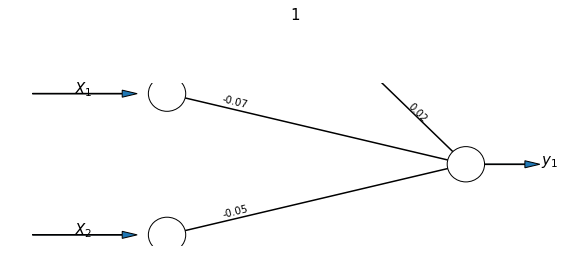

In [21]:
# Show learned model
w, b = model.layers[0].get_weights()
print('f(x) = sigmoid(%.4f + %.4f*x1 + %.4f*x2)' %(b[0], w[0], w[1]))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
draw_neural_net(ax, [2, 1], {0:w}, {0:b})
ax.axis('off');

Plot model performance:

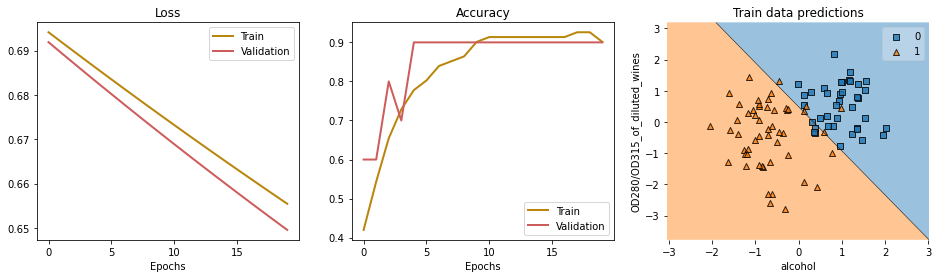

In [22]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_binary_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

# plot decision boundaries for train data
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=X_train_std, y=y_train,
                      clf=model)
ax.set_xlabel('alcohol', size=10)
ax.set_ylabel('OD280/OD315_of_diluted_wines', size=10)
ax.set_title('Train data predictions');

<span style="color:chocolate"> *Questions:*</span> 

1. How does the TensorFlow model accuracy on the train data compare with the manual implementation?

2. How does the TensorFlow model accuracy on the train data change if you set the initial weights to kernel_initializer='random_normal' and bias_initializer='zeros'?  (see build_model() function).

3. How does the TensorFlow model accuracy on the train data change if you set batch_size to 10 for example? (see model.fit()).

Prediction (on training and test data)

In [23]:
# run the trained model on the test data (the model outputs probabilities)
y_train_pred_tf = model.predict(x=X_train_std).flatten()

# apply the threshold function to create a 0, 1 outcome
y_train_pred_tf = np.where(y_train_pred_tf>=0.5, 1, 0)
y_train_pred_tf

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1])

In [24]:
# run the trained model on the test data (the model outputs probabilities)
y_test_pred_tf = model.predict(x=X_test_std).flatten()

# apply the threshold function to create a 0, 1 outcome
y_test_pred_tf = np.where(y_test_pred_tf>=0.5, 1, 0)
y_test_pred_tf

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0])

In [25]:
# compare with the actual values (ground truth) in test data
y_test

array([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0])

Evaluation (on training and test data)

In [26]:
# print accuracy for train
print('Training, misclassified examples: %d' % (y_train != y_train_pred_tf).sum())
error_train_tf = (y_train != y_train_pred_tf).sum()/len(y_train_pred_tf)
print('Training, prediction accuracy: %.3f'% (1-error_train_tf))

# print accuracy for test
print('------------')
print('Test, misclassified examples: %d' % (y_test != y_test_pred_tf).sum())
error_test_tf = (y_test != y_test_pred_tf).sum()/len(y_test_pred_tf)
print('Test, prediction accuracy: %.3f'% (1-error_test_tf))

Training, misclassified examples: 9
Training, prediction accuracy: 0.901
------------
Test, misclassified examples: 4
Test, prediction accuracy: 0.897


Next, we want to visualize how well Logistic Regression separates the 2 different wine cultivars in the test data.

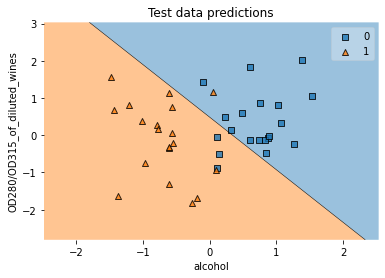

In [27]:
# plot decision boundaries for test data
plot_decision_regions(X=X_test_std, y=y_test,
                      clf=model)
plt.xlabel('alcohol', size=10)
plt.ylabel('OD280/OD315_of_diluted_wines', size=10)
plt.title('Test data predictions');

<span style="color:chocolate"> *Question:*</span> Can you identify the misclassified examples in the decision boundary plot above?

``More on Performance Evaluation Metrics``

We evaluated the performance of our Logistic Regression model using the **prediction error** and **prediction accuracy**, which are useful metrics but not the only one we can use to check a model performance.

Other performance metrics that we can use include **precision**, **recall**, and the **F1 score**. Before I show you how to implement them, let's take a look at the **confusion matrix**.

A confusion matrix is a square matrix that reports the count of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN).

Image source: Python Machine Learning 3rd Edition by [Sebastian Raschka] 



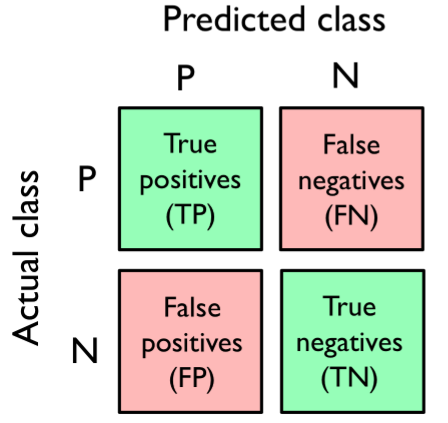

In [28]:
print('Image source: Python Machine Learning 3rd Edition by [Sebastian Raschka] \n')
Image(filename='./images/confusion_matrix.png', width=200) 

The **precision** and **recall** metrics are related to the TP and TN rates, as follows:

$precision = \frac{TP}{TP + FP}$, emphasizes correctness, but doesn't pay attention to FN.

$recall = \frac{TP}{TP+FN}$, minimizes the chance of not detecting a FN, but doesn't pay attention to FP.

The **F1 score** provides a balance (harmonic mean) between the precission and recall metrics:

$F1 = 2 \times \frac{precision * recall}{precision + recall}$

Let's go back to our wine data now to see the results of the confusion matrix applied on the test data.

In [29]:
conf_matrix = tf.math.confusion_matrix(
    y_test,
    y_test_pred_tf,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[17,  3],
       [ 1, 18]], dtype=int32)>

Let's plot the conf_matrix in a format that makes it easier to read.

Question: How do you interpret the results?

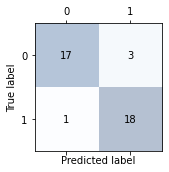

In [30]:
confusion_matrix_plot(conf_matrix.numpy())

Let's now look at the value of precision, recall, and F1 metrics. No need to write our own formulas, we can use the methods implemented in TensorFlow.

In [31]:
# note that TensorFlow assumes that the positive class is cultivar 1
p = tf.keras.metrics.Precision(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
p.update_state(y_test, y_test_pred_tf)  #18/(18+3)
print("Precision score: %3f" %p.result().numpy())

Precision score: 0.857143


In [32]:
# note that TensorFlow assumes that the positive class is cultivar 1
r = tf.keras.metrics.Recall(
    thresholds=None, top_k=None, class_id=None, name=None, dtype=None
)
r.update_state(y_test, y_test_pred_tf) #18/(18+1)
print("Recall score: %.3f" %r.result().numpy())

Recall score: 0.947


In [33]:
print("F1 score:",
    2*((p.result().numpy()*r.result().numpy())/(p.result().numpy()+r.result().numpy())))

F1 score: 0.8999999761581421


<span style="color:chocolate"> *Question:*</span> Which class is the most difficult for the Logistic Regression model to recognize?

---
### Breakout room exercise

You will create a new notebook, and you will be working with the **diabetes.csv** dataset from **week02**. To make it easier for you, the code below imports the data.

In [34]:
df = pd.read_csv(
    'https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt',
    delimiter='\t'
)

df.columns = [
    'age', 'sex', 'bmi', 'map',
    'tc', 'ldl', 'hdl', 'tch',
    'ltg', 'glu', 'disease_progression']

df.head(2)

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,disease_progression
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75


Here are the tasks:
   - [a] Define an outcome of interest
   - [a] Preprocess the data (e.g. split data into training and test) <br>
   - [b] Define a Logistic Regression model to predict your outcome of interest using TensorFlow. Comment on classification accuracy on training vs. test partitions. <br>

Good luck!